# ENSEMBLE DES GRAPHIQUES / TABLEAUX POUR LE RAPPORT 

In [4]:
# 10_EXPORT_RESULT.py
from pathlib import Path
import json
import pandas as pd

# 1) Répertoires
import os

# Si on est dans un notebook, on prend le cwd (répertoire courant)
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    SCRIPT_DIR = Path(os.getcwd()).resolve()

MODELS_DIR  = SCRIPT_DIR / "data" / "models"   # <-- ton chemin
print("MODELS_DIR =", MODELS_DIR)
if not MODELS_DIR.exists():
    raise FileNotFoundError(f"Dossier introuvable: {MODELS_DIR}")

# 2) Chemins des fichiers attendus
har_metrics_path   = MODELS_DIR / "har_rv" / "metrics.json"
garch_metrics_path = MODELS_DIR / "garch_plus" / "metrics.json"
lstm_metrics_h1    = MODELS_DIR / "lstm" / "lstm_target_sigma1_enriched_log_metrics.json"
lstm_metrics_h5    = MODELS_DIR / "lstm" / "lstm_target_vol5f_enriched_log_metrics.json"

def read_json(p: Path, required=True):
    if not p.exists():
        msg = f"Fichier manquant: {p}"
        if required:
            raise FileNotFoundError(msg)
        else:
            print("[AVERTISSEMENT]", msg)
            return None
    return json.loads(p.read_text(encoding="utf-8"))

# 3) Lecture des métriques
har_metrics   = read_json(har_metrics_path,   required=True)   # contient EWM/HAR pour 1j (sigma1) et 5j (vol5f)
lstm_h1       = read_json(lstm_metrics_h1,    required=False)  # LSTM/Blend 1j
lstm_h5       = read_json(lstm_metrics_h5,    required=False)  # LSTM/Blend 5j
garch_metrics = read_json(garch_metrics_path, required=False)  # EWM/EGARCH/GJR 1j

rows = []

# 4) HAR-RV et EWM (1j et 5j) depuis har_rv/metrics.json
# sigma1
rows.append({"Modèle":"EWM",   "MAE (1j)":har_metrics["sigma1"]["ewm_mae"], "RMSE (1j)":har_metrics["sigma1"]["ewm_rmse"]})
rows.append({"Modèle":"HAR-RV","MAE (1j)":har_metrics["sigma1"]["har_mae"], "RMSE (1j)":har_metrics["sigma1"]["har_rmse"]})
# vol5f
# on crée les colonnes 5j ; on laissera vides celles non concernées
rows.append({"Modèle":"EWM",   "MAE (5j)":har_metrics["vol5f"]["ewm_mae"], "RMSE (5j)":har_metrics["vol5f"]["ewm_rmse"]})
rows.append({"Modèle":"HAR-RV","MAE (5j)":har_metrics["vol5f"]["har_mae"], "RMSE (5j)":har_metrics["vol5f"]["har_rmse"]})

# 5) LSTM et Blend (si présents)
def add_lstm_block(js, horizon_tag):
    if js is None: 
        return []
    mae_lstm = js.get("test_mae_pct_points_lstm")
    rmse_lstm = js.get("test_rmse_pct_points_lstm")
    mae_blend = js.get("test_mae_pct_points_blend")
    rmse_blend = js.get("test_rmse_pct_points_blend")
    out = []
    if horizon_tag == "1j":
        out += [{"Modèle":"LSTM",  "MAE (1j)":mae_lstm,  "RMSE (1j)":rmse_lstm}]
        out += [{"Modèle":"Blend", "MAE (1j)":mae_blend, "RMSE (1j)":rmse_blend}]
    else:
        out += [{"Modèle":"LSTM",  "MAE (5j)":mae_lstm,  "RMSE (5j)":rmse_lstm}]
        out += [{"Modèle":"Blend", "MAE (5j)":mae_blend, "RMSE (5j)":rmse_blend}]
    return out

rows += add_lstm_block(lstm_h1, "1j")
rows += add_lstm_block(lstm_h5, "5j")

# 6) EGARCH / GJR (h=1 uniquement) si dispo
if garch_metrics:
    for rec in garch_metrics:
        model = rec.get("model")
        mae   = rec.get("mae")
        rmse  = rec.get("rmse")
        # certains JSON listent aussi EWM ici ; on ne duplique pas si déjà ajouté
        if model and model.upper() != "EWM":
            rows.append({"Modèle":model, "MAE (1j)":mae, "RMSE (1j)":rmse})

# 7) Construction du tableau large
df = pd.DataFrame(rows)
# Agréger les doublons éventuels (ex : EWM ajouté côté HAR et LSTM) en gardant la valeur non nulle
df = df.groupby("Modèle").agg({
    "MAE (1j)":"min", "RMSE (1j)":"min",
    "MAE (5j)":"min", "RMSE (5j)":"min"
}).reset_index()

# 8) Ajouter les colonnes QLIKE vides (non exportées dans tes JSON)
df["QLIKE (1j)"] = pd.NA
df["QLIKE (5j)"] = pd.NA

# 9) Ordonner les colonnes et lignes
order_cols = ["Modèle","MAE (1j)","RMSE (1j)","QLIKE (1j)","MAE (5j)","RMSE (5j)","QLIKE (5j)"]
df = df.reindex(columns=order_cols)
order_rows = ["EWM","GARCH","EGARCH(1,1)","GJR(1,1)","HAR-RV","LSTM","Blend"]
df["__ord"] = df["Modèle"].apply(lambda m: order_rows.index(m) if m in order_rows else 99)
df = df.sort_values("__ord").drop(columns="__ord").reset_index(drop=True)

# 10) Exports rapport-ready
out_dir = SCRIPT_DIR / "data" / "tables"
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "tableau_X_metrics_mae_rmse_qlike.csv"
md_path  = out_dir / "tableau_X_metrics_mae_rmse_qlike.md"

df.to_csv(csv_path, index=False)
with open(md_path, "w", encoding="utf-8") as f:
    f.write(df.to_markdown(index=False))

print("Tableau X exporté :")
print(" - CSV :", csv_path)
print(" - MD  :", md_path)
print(df)


MODELS_DIR = C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\notebook\data\models
Tableau X exporté :
 - CSV : C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\notebook\data\tables\tableau_X_metrics_mae_rmse_qlike.csv
 - MD  : C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\notebook\data\tables\tableau_X_metrics_mae_rmse_qlike.md
        Modèle  MAE (1j)  RMSE (1j) QLIKE (1j)  MAE (5j)  RMSE (5j) QLIKE (5j)
0          EWM  9.839338  13.406537       <NA>  5.545787   8.328500       <NA>
1  EGARCH(1,1)  2.309317   3.128790       <NA>       NaN        NaN       <NA>
2     GJR(1,1)  2.879815   4.278889       <NA>       NaN        NaN       <NA>
3       HAR-RV  8.672426  12.656261       <NA>  5.258936   7.926629       <NA>
4         LSTM  7.783555  11.890776       <NA>  4.542500   6.909425       <NA>
5  

[HAR-h1] colonnes trouvées : {'EWM': 'ewm', 'HAR': 'y_pred_har'}
[LSTM-h1] colonnes trouvées : {'LSTM': 'y_lstm', 'Blend': 'y_blend', 'EWM': 'y_ewm'}


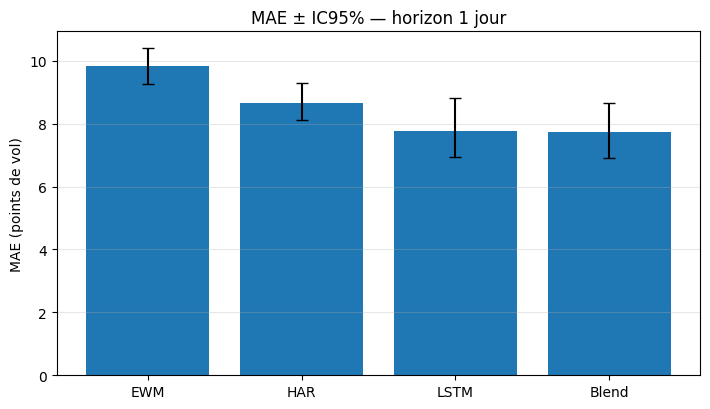

[HAR-h5] colonnes trouvées : {'EWM': 'ewm', 'HAR': 'y_pred_har'}
[LSTM-h5] colonnes trouvées : {'LSTM': 'y_lstm', 'Blend': 'y_blend', 'EWM': 'y_ewm'}


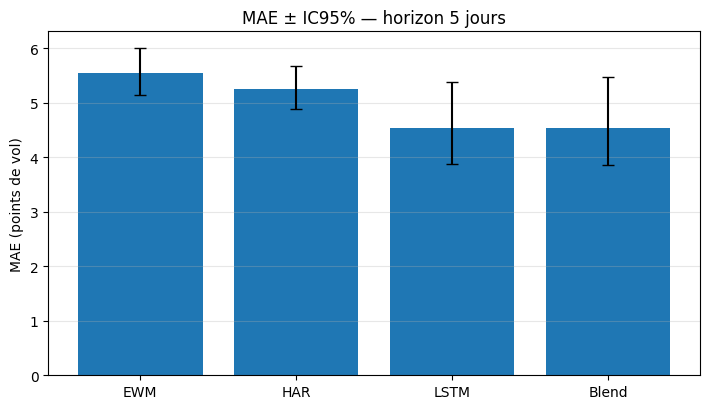

In [5]:
# === Figure Y : MAE + IC95% (h=1j & 5j) — version robuste aux noms de colonnes ===
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

HAR_DIR  = Path("data/models/har_rv")
LSTM_DIR = Path("data/models/lstm")

files = {
    "h1": {"har": HAR_DIR/"har_sigma1_test.csv",
           "lstm": LSTM_DIR/"lstm_target_sigma1_enriched_log_test.csv"},
    "h5": {"har": HAR_DIR/"har_vol5f_test.csv",
           "lstm": LSTM_DIR/"lstm_target_vol5f_enriched_log_test.csv"},
}

# ---------- helpers ----------
def find_col(df, candidates):
    """Retourne le 1er nom de colonne existant parmi candidates (liste ou dict {label:[cands...]})"""
    if isinstance(candidates, dict):
        out = {}
        for label, cands in candidates.items():
            out[label] = next((c for c in cands if c in df.columns), None)
        return out
    return next((c for c in candidates if c in df.columns), None)

def moving_block_bootstrap_mae(err, block=21, n_boot=800, rng=None):
    rng = np.random.default_rng(rng)
    n = len(err); b = block; k = int(np.ceil(n/b))
    maes = np.empty(n_boot)
    for i in range(n_boot):
        idx = []
        for _ in range(k):
            s = rng.integers(0, n-b+1)
            idx.extend(range(s, s+b))
        idx = np.array(idx[:n])
        maes[i] = np.mean(np.abs(err[idx]))
    est = np.mean(np.abs(err))
    lo, hi = np.percentile(maes, [2.5, 97.5])
    return est, (lo, hi)

def mae_ci(df, col_pred, col_true="y_true"):
    err = df[col_pred].to_numpy() - df[col_true].to_numpy()
    return moving_block_bootstrap_mae(err, block=21, n_boot=800)

def collect_mae_ci(hkey):
    results = {}

    # ----- HAR file -----
    df_har = pd.read_csv(files[hkey]["har"])
    # détecter y_true + colonnes modèles
    y_true_col = find_col(df_har, ["y_true","target","y"])
    if y_true_col != "y_true":
        df_har = df_har.rename(columns={y_true_col:"y_true"})
    cols_har = find_col(df_har, {
        "EWM":   ["y_ewm","ewm","vol_ewm","y_pred_ewm","ewm_pred"],
        "HAR":   ["y_pred_har","y_har","har","pred_har"],
    })
    print(f"[HAR-{hkey}] colonnes trouvées :", cols_har)
    if cols_har["EWM"]:
        results["EWM"] = mae_ci(df_har, cols_har["EWM"])
    else:
        print(f"⚠️  EWM introuvable dans le fichier HAR {files[hkey]['har'].name}")

    if cols_har["HAR"]:
        results["HAR"] = mae_ci(df_har, cols_har["HAR"])
    else:
        print(f"⚠️  HAR introuvable dans {files[hkey]['har'].name}")

    # ----- LSTM file -----
    df_lstm = pd.read_csv(files[hkey]["lstm"])
    y_true_col = find_col(df_lstm, ["y_true","target","y"])
    if y_true_col != "y_true":
        df_lstm = df_lstm.rename(columns={y_true_col:"y_true"})
    cols_lstm = find_col(df_lstm, {
        "LSTM":  ["y_lstm","lstm","y_pred_lstm","pred_lstm"],
        "Blend": ["y_blend","blend","y_pred_blend","pred_blend"],
        "EWM":   ["y_ewm","ewm","vol_ewm","y_pred_ewm","ewm_pred"],  # au cas où EWM est ici
    })
    print(f"[LSTM-{hkey}] colonnes trouvées :", cols_lstm)

    if "EWM" not in results and cols_lstm["EWM"]:
        results["EWM"] = mae_ci(df_lstm, cols_lstm["EWM"])
    if cols_lstm["LSTM"]:
        results["LSTM"] = mae_ci(df_lstm, cols_lstm["LSTM"])
    else:
        print(f"⚠️  LSTM introuvable dans {files[hkey]['lstm'].name}")
    if cols_lstm["Blend"]:
        results["Blend"] = mae_ci(df_lstm, cols_lstm["Blend"])

    return results

def plot_bar_mae(results, title, out_png):
    labels = list(results.keys())
    means  = [results[k][0] for k in labels]
    lo     = [results[k][1][0] for k in labels]
    hi     = [results[k][1][1] for k in labels]
    yerr   = [np.array(means)-np.array(lo), np.array(hi)-np.array(means)]
    plt.figure(figsize=(7.2,4.2))
    plt.bar(labels, means, yerr=yerr, capsize=4)
    plt.ylabel("MAE (points de vol)")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    Path(out_png).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png, dpi=200)
    plt.show()

# ---- Génération h=1j et h=5j ----
res_h1 = collect_mae_ci("h1")
plot_bar_mae(res_h1, "MAE ± IC95% — horizon 1 jour", "data/models/lstm/barplot_mae_h1.png")

res_h5 = collect_mae_ci("h5")
plot_bar_mae(res_h5, "MAE ± IC95% — horizon 5 jours", "data/models/lstm/barplot_mae_h5.png")


[HAR-h1] colonnes trouvées : {'EWM': 'ewm', 'HAR': 'y_pred_har'}
[LSTM-h1] colonnes trouvées : {'LSTM': 'y_lstm', 'Blend': 'y_blend', 'EWM': 'y_ewm'}


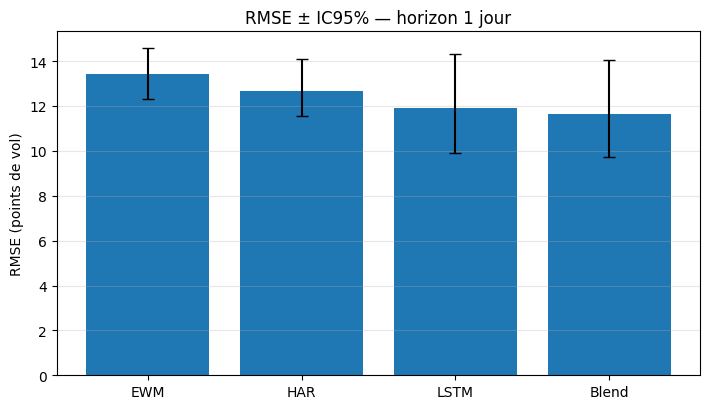

[HAR-h5] colonnes trouvées : {'EWM': 'ewm', 'HAR': 'y_pred_har'}
[LSTM-h5] colonnes trouvées : {'LSTM': 'y_lstm', 'Blend': 'y_blend', 'EWM': 'y_ewm'}


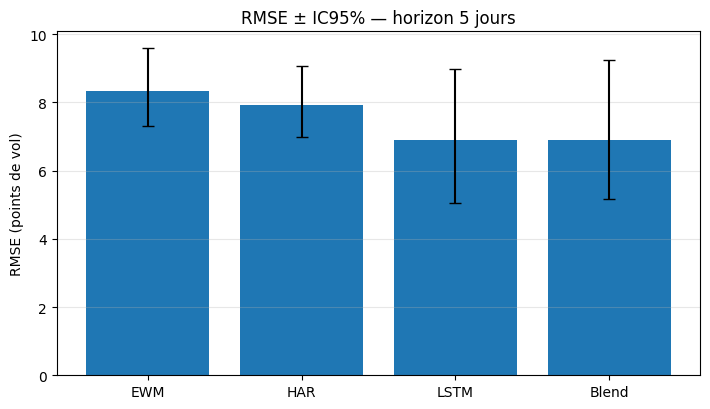

[HAR-h1] colonnes trouvées : {'EWM': 'ewm', 'HAR': 'y_pred_har'}
[LSTM-h1] colonnes trouvées : {'LSTM': 'y_lstm', 'Blend': 'y_blend', 'EWM': 'y_ewm'}


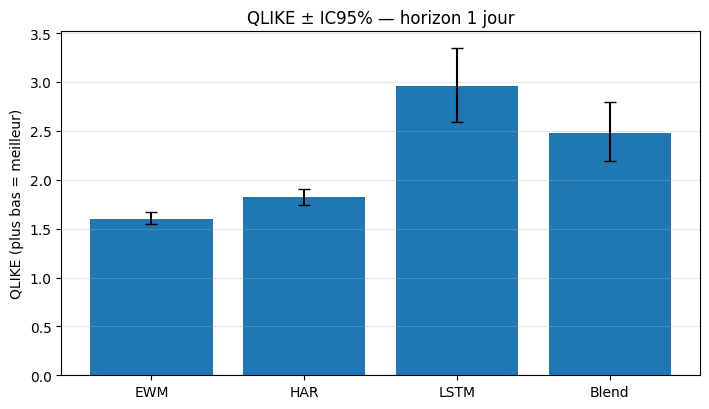

[HAR-h5] colonnes trouvées : {'EWM': 'ewm', 'HAR': 'y_pred_har'}
[LSTM-h5] colonnes trouvées : {'LSTM': 'y_lstm', 'Blend': 'y_blend', 'EWM': 'y_ewm'}


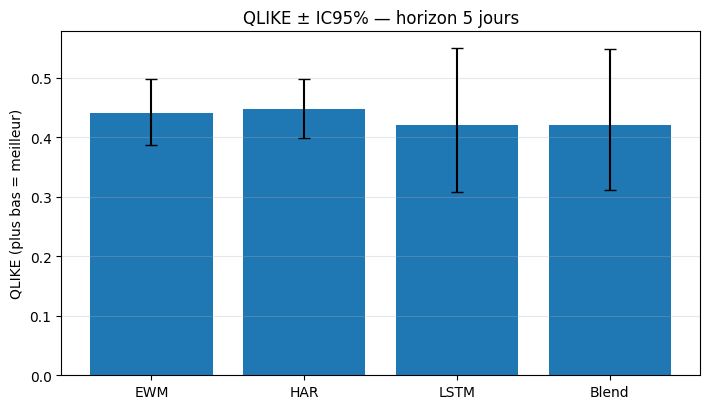

In [6]:
# === Figure Z : RMSE & QLIKE + IC95% (h=1j & 5j) — version robuste ===
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

HAR_DIR  = Path("data/models/har_rv")
LSTM_DIR = Path("data/models/lstm")

files = {
    "h1": {"har": HAR_DIR/"har_sigma1_test.csv",
           "lstm": LSTM_DIR/"lstm_target_sigma1_enriched_log_test.csv"},
    "h5": {"har": HAR_DIR/"har_vol5f_test.csv",
           "lstm": LSTM_DIR/"lstm_target_vol5f_enriched_log_test.csv"},
}

# ---------- helpers ----------
def find_col(df, candidates):
    if isinstance(candidates, dict):
        out = {}
        for label, cands in candidates.items():
            out[label] = next((c for c in cands if c in df.columns), None)
        return out
    return next((c for c in candidates if c in df.columns), None)

def moving_block_bootstrap(loss_series, block=21, n_boot=800, rng=None):
    rng = np.random.default_rng(rng)
    n = len(loss_series); b = block; k = int(np.ceil(n/b))
    stats = np.empty(n_boot)
    for i in range(n_boot):
        idx = []
        for _ in range(k):
            s = rng.integers(0, n-b+1)
            idx.extend(range(s, s+b))
        idx = np.array(idx[:n])
        stats[i] = np.mean(loss_series[idx])
    est = np.mean(loss_series)
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return est, (lo, hi)

def rmse_ci(df, col_pred, col_true="y_true"):
    e = df[col_pred].to_numpy() - df[col_true].to_numpy()
    loss = e**2
    mse, (lo, hi) = moving_block_bootstrap(loss, block=21, n_boot=800)
    rmse = np.sqrt(mse)
    # Transformer les bornes en RMSE en restant conservateur (racine des bornes)
    return rmse, (np.sqrt(lo), np.sqrt(hi))

def qlike_ci(df, col_pred, col_true="y_true"):
    """
    QLIKE sur la variance: v/f - log(v/f) - 1, avec v = y_true^2, f = y_pred^2.
    Suppose y_true,y_pred > 0 (volatilités). Ajoute un epsilon pour stabilité.
    """
    eps = 1e-12
    v = np.maximum(df[col_true].to_numpy(), eps)**2
    f = np.maximum(df[col_pred].to_numpy(), eps)**2
    ratio = v / f
    loss = ratio - np.log(ratio) - 1.0
    return moving_block_bootstrap(loss, block=21, n_boot=800)

def collect_cols(df, spec):
    y_true_col = find_col(df, ["y_true","target","y"])
    if y_true_col != "y_true":
        df = df.rename(columns={y_true_col:"y_true"})
    cols = find_col(df, spec)
    return df, cols

def load_data(hkey):
    # HAR
    df_har = pd.read_csv(files[hkey]["har"])
    df_har, cols_har = collect_cols(df_har, {
        "EWM":   ["y_ewm","ewm","vol_ewm","y_pred_ewm","ewm_pred"],
        "HAR":   ["y_pred_har","y_har","har","pred_har"],
    })
    print(f"[HAR-{hkey}] colonnes trouvées :", cols_har)

    # LSTM
    df_lstm = pd.read_csv(files[hkey]["lstm"])
    df_lstm, cols_lstm = collect_cols(df_lstm, {
        "LSTM":  ["y_lstm","lstm","y_pred_lstm","pred_lstm"],
        "Blend": ["y_blend","blend","y_pred_blend","pred_blend"],
        "EWM":   ["y_ewm","ewm","vol_ewm","y_pred_ewm","ewm_pred"],
    })
    print(f"[LSTM-{hkey}] colonnes trouvées :", cols_lstm)
    return (df_har, cols_har), (df_lstm, cols_lstm)

def aggregate_metric(hkey, metric_fn):
    results = {}
    (df_har, cols_har), (df_lstm, cols_lstm) = load_data(hkey)

    # EWM/HAR
    if cols_har["EWM"]:
        results["EWM"] = metric_fn(df_har, cols_har["EWM"])
    elif cols_lstm["EWM"]:
        results["EWM"] = metric_fn(df_lstm, cols_lstm["EWM"])
    else:
        print("⚠️ EWM introuvable dans les fichiers HAR/LSTM.")

    if cols_har["HAR"]:
        results["HAR"] = metric_fn(df_har, cols_har["HAR"])

    # LSTM/Blend
    if cols_lstm["LSTM"]:
        results["LSTM"] = metric_fn(df_lstm, cols_lstm["LSTM"])
    if cols_lstm["Blend"]:
        results["Blend"] = metric_fn(df_lstm, cols_lstm["Blend"])

    return results

def barplot_with_ci(results, ylabel, title, out_png):
    labels = list(results.keys())
    means  = [results[k][0] for k in labels]
    lo     = [results[k][1][0] for k in labels]
    hi     = [results[k][1][1] for k in labels]
    yerr   = [np.array(means)-np.array(lo), np.array(hi)-np.array(means)]
    plt.figure(figsize=(7.2,4.2))
    plt.bar(labels, means, yerr=yerr, capsize=4)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    Path(out_png).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png, dpi=200)
    plt.show()

# ---------- RMSE ----------
rmse_h1 = aggregate_metric("h1", rmse_ci)
barplot_with_ci(rmse_h1, "RMSE (points de vol)", "RMSE ± IC95% — horizon 1 jour",
                "data/models/lstm/barplot_rmse_h1.png")

rmse_h5 = aggregate_metric("h5", rmse_ci)
barplot_with_ci(rmse_h5, "RMSE (points de vol)", "RMSE ± IC95% — horizon 5 jours",
                "data/models/lstm/barplot_rmse_h5.png")

# ---------- QLIKE ----------
qlike_h1 = aggregate_metric("h1", qlike_ci)
barplot_with_ci(qlike_h1, "QLIKE (plus bas = meilleur)", "QLIKE ± IC95% — horizon 1 jour",
                "data/models/lstm/barplot_qlike_h1.png")

qlike_h5 = aggregate_metric("h5", qlike_ci)
barplot_with_ci(qlike_h5, "QLIKE (plus bas = meilleur)", "QLIKE ± IC95% — horizon 5 jours",
                "data/models/lstm/barplot_qlike_h5.png")


In [7]:
# === Tableau Y : Diebold–Mariano (HAR vs EWM, LSTM vs EWM, LSTM vs HAR) — h=1 & h=5 ===
from pathlib import Path
import numpy as np, pandas as pd
from math import floor
from scipy.stats import t as student_t

BASE = Path("data/models")
HAR_DIR  = BASE / "har_rv"
LSTM_DIR = BASE / "lstm"
OUT_DIR  = BASE / "dm_tests"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FILES = {
    "h1": {
        "har":  HAR_DIR / "har_sigma1_test.csv",
        "lstm": LSTM_DIR / "lstm_target_sigma1_enriched_log_test.csv",
    },
    "h5": {
        "har":  HAR_DIR / "har_vol5f_test.csv",
        "lstm": LSTM_DIR / "lstm_target_vol5f_enriched_log_test.csv",
    }
}

def find_col(df, candidates):
    return next((c for c in candidates if c in df.columns), None)

def load_pair(hkey):
    # --- HAR ---
    df_har = pd.read_csv(FILES[hkey]["har"], parse_dates=["date"])
    y_true_h = find_col(df_har, ["y_true","target","y"])
    y_ewm_h  = find_col(df_har, ["y_ewm","ewm","vol_ewm","y_pred_ewm","ewm_pred"])
    y_har    = find_col(df_har, ["y_pred_har","y_har","har","pred_har"])
    if y_true_h is None or y_har is None:
        raise ValueError(f"[{hkey}] Fichier HAR incomplet: colonnes trouvées={df_har.columns.tolist()}")
    ren_h = {y_true_h:"y_true", y_har:"y_har"}
    if y_ewm_h: ren_h[y_ewm_h] = "y_ewm"
    df_har = df_har.rename(columns=ren_h)

    # --- LSTM ---
    df_lstm = pd.read_csv(FILES[hkey]["lstm"], parse_dates=["date"])
    y_true_l = find_col(df_lstm, ["y_true","target","y"])
    y_lstm   = find_col(df_lstm, ["y_lstm","lstm","y_pred_lstm","pred_lstm"])
    y_blend  = find_col(df_lstm, ["y_blend","blend","y_pred_blend","pred_blend"])
    y_ewm_l  = find_col(df_lstm, ["y_ewm","ewm","vol_ewm","y_pred_ewm","ewm_pred"])
    if y_true_l is None or y_lstm is None:
        raise ValueError(f"[{hkey}] Fichier LSTM incomplet: colonnes trouvées={df_lstm.columns.tolist()}")
    ren_l = {y_true_l:"y_true", y_lstm:"y_lstm"}
    if y_blend: ren_l[y_blend] = "y_blend"
    if y_ewm_l: ren_l[y_ewm_l] = "y_ewm"
    df_lstm = df_lstm.rename(columns=ren_l)

    return df_har, df_lstm

def newey_west_var(d, L):
    d = np.asarray(d, dtype=float)
    n = d.size
    d = d - np.nanmean(d)
    gamma0 = np.nanmean(d*d)
    s = gamma0
    for k in range(1, L+1):
        w = 1 - k/(L+1)          # Bartlett
        gamma = np.nanmean(d[k:] * d[:-k])
        s += 2 * w * gamma
    return s / n

def dm_test(y_true, f1, f2, h=1, loss="mse"):
    y_true = np.asarray(y_true, dtype=float)
    f1 = np.asarray(f1, dtype=float)
    f2 = np.asarray(f2, dtype=float)

    if loss == "mse":
        d = (y_true - f1)**2 - (y_true - f2)**2
    elif loss == "qlike":
        eps = 1e-12
        v = np.maximum(y_true, eps)**2
        f1v = np.maximum(f1, eps)**2
        f2v = np.maximum(f2, eps)**2
        L1 = v/f1v - np.log(v/f1v) - 1.0
        L2 = v/f2v - np.log(v/f2v) - 1.0
        d = L1 - L2
    else:
        raise ValueError("loss must be 'mse' or 'qlike'")

    mask = np.isfinite(d)
    d = d[mask]
    n = d.size
    if n < 10:
        return np.nan, np.nan

    L = max(h-1, floor(n**(1/3)))
    var = newey_west_var(d, L)
    dm = np.nanmean(d) / np.sqrt(var if var>0 else np.nan)
    # Harvey small-sample
    harv = np.sqrt((n + 1 - 2*h + h*(h-1)/n) / n)
    dm_adj = dm * harv
    p = 2 * (1 - student_t.cdf(np.abs(dm_adj), df=max(n-1,1)))
    return float(dm_adj), float(p)

def build_dm_table(hkey, horizon_h):
    df_har, df_lstm = load_pair(hkey)

    left_cols = ["date","y_true","y_har"]
    if "y_ewm" in df_har.columns: left_cols.append("y_ewm")

    right_cols = ["date","y_true","y_lstm"]
    if "y_blend" in df_lstm.columns: right_cols.append("y_blend")
    if "y_ewm" in df_lstm.columns:   right_cols.append("y_ewm")

    x = df_har[left_cols].merge(
        df_lstm[right_cols],
        on="date",
        suffixes=("_har","_lstm"),
        how="inner"
    )

    # y_true : privilégie HAR sinon LSTM
    if "y_true_har" in x: y = x["y_true_har"].to_numpy()
    elif "y_true_lstm" in x: y = x["y_true_lstm"].to_numpy()
    else: raise ValueError("Impossible de trouver y_true après fusion.")

    # EWM : prend HAR si dispo, sinon LSTM (le nom peut être suffixé ou non)
    ewm_candidates = ["y_ewm_har","y_ewm_lstm","y_ewm"]
    ewm_col = next((c for c in ewm_candidates if c in x.columns), None)
    if ewm_col is None:
        raise ValueError(f"[{hkey}] Baseline EWM introuvable dans les données fusionnées.")

    harv  = x["y_har"].to_numpy()
    lstm  = x["y_lstm"].to_numpy()
    ewm   = x[ewm_col].to_numpy()
    blend = x["y_blend"].to_numpy() if "y_blend" in x.columns else None

    rows = []
    # Paires principales
    pairs = [("HAR vs EWM",   harv, ewm),
             ("LSTM vs EWM",  lstm, ewm),
             ("LSTM vs HAR",  lstm, harv)]
    # (optionnel) ajouter Blend si présent
    if blend is not None:
        pairs += [("Blend vs EWM", blend, ewm), ("Blend vs HAR", blend, harv), ("Blend vs LSTM", blend, lstm)]

    for name, f1, f2 in pairs:
        # aligne les masques
        mask = np.isfinite(y) & np.isfinite(f1) & np.isfinite(f2)
        stat, p_mse = dm_test(y[mask], f1[mask], f2[mask], h=horizon_h, loss="mse")
        rows.append({"Horizon": hkey, "Comparison": name, "Loss": "MSE", "DM_stat": stat, "p_value": p_mse})

    df = pd.DataFrame(rows)
    out_csv = OUT_DIR / f"dm_summary_{hkey}.csv"
    df.to_csv(out_csv, index=False)
    (OUT_DIR / f"dm_summary_{hkey}.md").write_text(df.to_markdown(index=False, floatfmt=".4f"), encoding="utf-8")
    print(f"✓ Sauvé: {out_csv}")
    print(df.to_markdown(index=False, floatfmt=".4f"))
    return df

dm_h1 = build_dm_table("h1", horizon_h=1)
dm_h5 = build_dm_table("h5", horizon_h=5)

# Fusion des deux horizons pour le Tableau Y
tableau_Y = pd.concat([dm_h1, dm_h5], ignore_index=True)
tableau_Y.to_csv(OUT_DIR/"Tableau_Y_DM_tests.csv", index=False)
print("\n== Tableau Y (résumé) ==\n", tableau_Y.to_markdown(index=False, floatfmt=".4f"))


✓ Sauvé: data\models\dm_tests\dm_summary_h1.csv
| Horizon   | Comparison    | Loss   |   DM_stat |   p_value |
|:----------|:--------------|:-------|----------:|----------:|
| h1        | HAR vs EWM    | MSE    |   -2.6868 |    0.0073 |
| h1        | LSTM vs EWM   | MSE    |   -0.8915 |    0.3728 |
| h1        | LSTM vs HAR   | MSE    |    1.4184 |    0.1563 |
| h1        | Blend vs EWM  | MSE    |   -1.7480 |    0.0807 |
| h1        | Blend vs HAR  | MSE    |    0.0285 |    0.9773 |
| h1        | Blend vs LSTM | MSE    |   -5.9081 |    0.0000 |
✓ Sauvé: data\models\dm_tests\dm_summary_h5.csv
| Horizon   | Comparison    | Loss   |   DM_stat |   p_value |
|:----------|:--------------|:-------|----------:|----------:|
| h5        | HAR vs EWM    | MSE    |   -0.0588 |    0.9531 |
| h5        | LSTM vs EWM   | MSE    |   -2.5148 |    0.0120 |
| h5        | LSTM vs HAR   | MSE    |   -3.3891 |    0.0007 |
| h5        | Blend vs EWM  | MSE    |   -2.5148 |    0.0120 |
| h5        | Blend vs

In [8]:
# === TABLEAU X — PnL moyen, écart-type, Sharpe (robuste aux colonnes en str) ===
import pandas as pd
from pathlib import Path

OUT = Path("data/backtests/options")

def load_raw_summary(path, horizon_label):
    df = pd.read_csv(path)
    df.insert(0, "Horizon", horizon_label)
    return df

def to_float(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def normalize_columns(df):
    # Renommage des colonnes (s'adapte à ton export "pnl, pnl.1, pnl.2, ret, ret.1, ret.2, ret.3")
    ren = {}

    if "model" in df.columns: ren["model"] = "Modèle"
    if "Unnamed: 0" in df.columns: ren["Unnamed: 0"] = "Modèle"

    # PnL
    if "pnl"   in df.columns: ren["pnl"]   = "pnl_mean"
    if "pnl.1" in df.columns: ren["pnl.1"] = "pnl_std"
    if "pnl.2" in df.columns: ren["pnl.2"] = "pnl_count"

    # Ret
    if "ret"   in df.columns: ren["ret"]   = "ret_mean"
    if "ret.1" in df.columns: ren["ret.1"] = "ret_std"
    if "ret.2" in df.columns: ren["ret.2"] = "ret_count"
    # parfois 'ret.3' = Sharpe-like
    if "ret.3" in df.columns: ren["ret.3"] = "sharpe_like"

    df = df.rename(columns=ren)

    # forcer numérique
    df = to_float(df, ["pnl_mean","pnl_std","ret_mean","ret_std","sharpe_like"])

    # calcul Sharpe si manquant
    if "sharpe_like" not in df.columns or df["sharpe_like"].isna().all():
        if {"ret_mean","ret_std"}.issubset(df.columns):
            df["sharpe_like"] = df["ret_mean"] / df["ret_std"]

    # colonnes finales
    keep = ["Horizon","Modèle","pnl_mean","pnl_std","ret_mean","ret_std","sharpe_like"]
    for k in keep:
        if k not in df.columns:
            df[k] = pd.NA
    return df[keep]

def order_models(df):
    order = ["EWM","HAR","LSTM","Blend"]
    if "Modèle" in df.columns:
        df["Modèle"] = pd.Categorical(df["Modèle"], categories=order, ordered=True)
        df = df.sort_values(["Horizon","Modèle"])
    return df.reset_index(drop=True)

# Charger
df1 = load_raw_summary(OUT/"bt_straddle_sigma1_summary.csv", "1 jour")
df5 = load_raw_summary(OUT/"bt_straddle_vol5f_summary.csv", "5 jours")

# Normaliser + fusionner
clean = pd.concat([normalize_columns(df1), normalize_columns(df5)], ignore_index=True)
clean = order_models(clean)

# Arrondir joliment
clean_rounded = clean.copy()
for c in ["pnl_mean","pnl_std","ret_mean","ret_std","sharpe_like"]:
    clean_rounded[c] = pd.to_numeric(clean_rounded[c], errors="coerce").round(4)

# Renommer FR lisible
clean_rounded = clean_rounded.rename(columns={
    "pnl_mean":"PnL moyen",
    "pnl_std":"PnL écart-type",
    "ret_mean":"Ret moyen",
    "ret_std":"Ret écart-type",
    "sharpe_like":"Sharpe"
})

# Export
clean_rounded.to_csv(OUT/"Tableau_X_PnL_summary_clean.csv", index=False)
md = clean_rounded.to_markdown(index=False, floatfmt=".4f")
(Path(OUT/"Tableau_X_PnL_summary.md")).write_text(md, encoding="utf-8")

print("== Tableau X (pro) — à copier dans Word ==\n")
print(md)

# Nettoyage final : suppression des lignes vides
clean_rounded = clean_rounded.dropna(subset=["Modèle"]).reset_index(drop=True)

# Réexporter sans lignes vides
clean_rounded.to_csv(OUT/"Tableau_X_PnL_summary_clean.csv", index=False)
md = clean_rounded.to_markdown(index=False, floatfmt=".4f")
(Path(OUT/"Tableau_X_PnL_summary.md")).write_text(md, encoding="utf-8")

print("== Tableau X (propre) — à copier dans Word ==\n")
print(md)



== Tableau X (pro) — à copier dans Word ==

| Horizon   | Modèle   |   PnL moyen |   PnL écart-type |   Ret moyen |   Ret écart-type |   Sharpe |
|:----------|:---------|------------:|-----------------:|------------:|-----------------:|---------:|
| 1 jour    | EWM      |      2.6259 |          63.4801 |      0.0587 |           0.3625 |   0.1620 |
| 1 jour    | HAR      |     36.8532 |          64.0986 |      0.3799 |           0.6414 |   0.5923 |
| 1 jour    | LSTM     |     76.9592 |          63.0910 |      0.9338 |           0.8084 |   1.1552 |
| 1 jour    | Blend    |     68.7699 |          60.0473 |      0.7573 |           0.6831 |   1.1086 |
| 1 jour    | nan      |    nan      |         nan      |    nan      |         nan      | nan      |
| 1 jour    | nan      |    nan      |         nan      |    nan      |         nan      | nan      |
| 5 jours   | EWM      |      2.6259 |          63.4801 |      0.0587 |           0.3625 |   0.1620 |
| 5 jours   | HAR      |     10.3162 |

C:\Users\antoi\AppData\Local\Temp\ipykernel_13260\445558376.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showmeans=True)


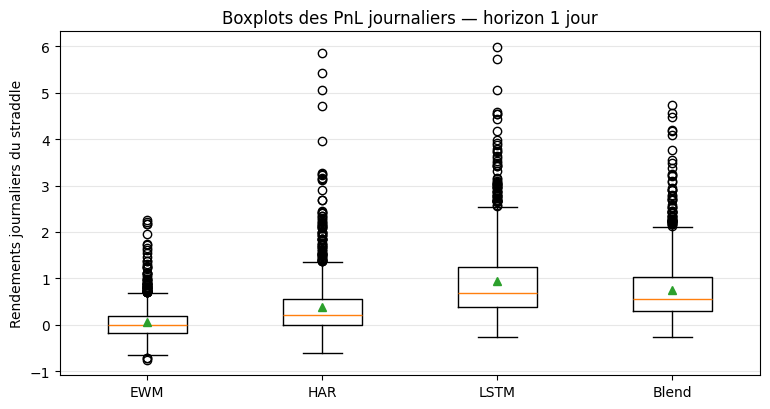

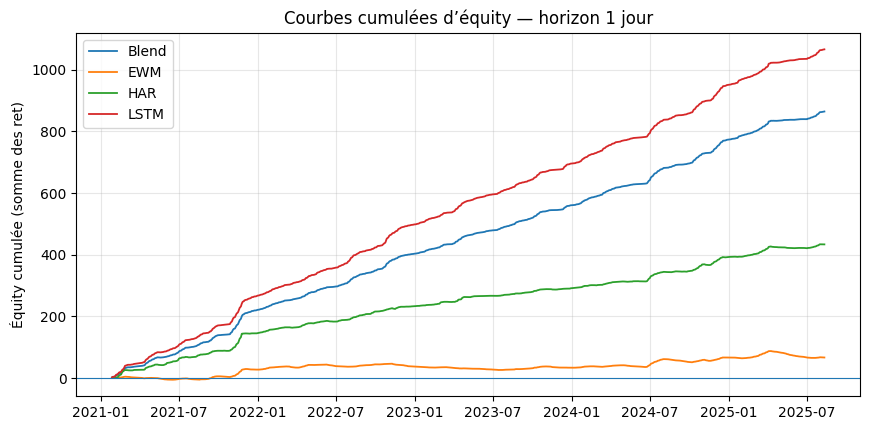

C:\Users\antoi\AppData\Local\Temp\ipykernel_13260\445558376.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showmeans=True)


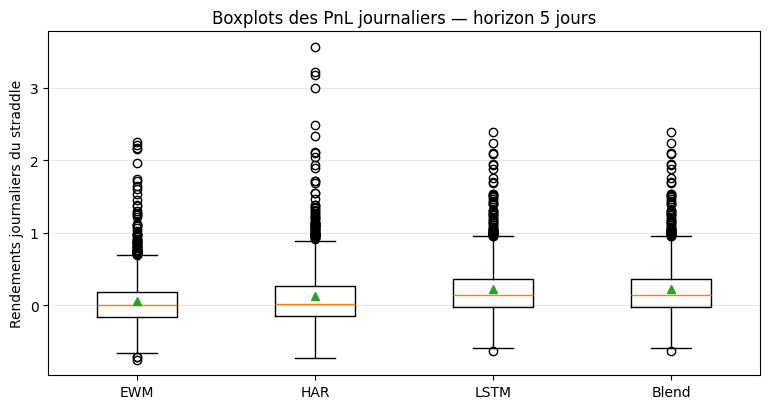

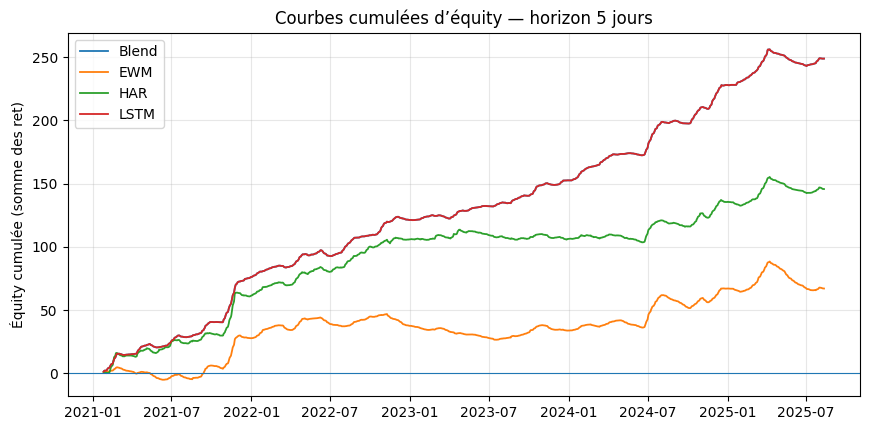

✓ Figures enregistrées dans :
- data\backtests\options\ret_box_sigma1.png
- data\backtests\options\ret_box_vol5f.png
- data\backtests\options\equity_curve_sigma1.png
- data\backtests\options\equity_curve_vol5f.png


In [9]:
# === Figures backtest : Boxplots PnL journaliers + Equity curves (h=1j & 5j) ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path("data/backtests/options")
FILES = {
    "sigma1": BASE / "bt_straddle_sigma1.csv",   # horizon 1j
    "vol5f":  BASE / "bt_straddle_vol5f.csv",    # horizon 5j
}
OUTS = {
    "box_sigma1":  BASE / "ret_box_sigma1.png",
    "box_vol5f":   BASE / "ret_box_vol5f.png",
    "eq_sigma1":   BASE / "equity_curve_sigma1.png",
    "eq_vol5f":    BASE / "equity_curve_vol5f.png",
}

def load_bt(path):
    # Lecture robuste (les colonnes peuvent varier légèrement suivant le notebook)
    df = pd.read_csv(path, parse_dates=[c for c in ["date","start"] if c in pd.read_csv(path, nrows=0).columns])
    # standardise date pour l’ordonnancement temporel
    if "date" not in df.columns:
        if "start" in df.columns:
            df = df.rename(columns={"start":"date"})
        else:
            # si pas de date, on fabrique un index temporel artificiel ordonné
            df["date"] = np.arange(len(df))
    # nom de la colonne rendement
    ret_col = "ret" if "ret" in df.columns else next((c for c in df.columns if c.lower().startswith("ret_") or c.lower()=="return"), None)
    if ret_col is None:
        raise ValueError(f"Aucune colonne rendement trouvée dans {path.name}.")
    # nom du modèle
    model_col = "model" if "model" in df.columns else next((c for c in df.columns if c.lower() in {"modele","Modèle","strategy","algo"}), None)
    if model_col is None:
        raise ValueError(f"Aucune colonne modèle trouvée dans {path.name}.")
    # nettoyage
    df = df[[model_col, "date", ret_col]].rename(columns={model_col:"model", ret_col:"ret"})
    df = df.dropna(subset=["model","ret"]).copy()
    return df

def ensure_dir(p): p.parent.mkdir(parents=True, exist_ok=True)

def boxplot_returns(df, title, out_png):
    ensure_dir(out_png)
    # ordre lisible
    order = [m for m in ["EWM","HAR","LSTM","Blend"] if m in df["model"].unique().tolist()]
    if not order: order = sorted(df["model"].unique())
    data = [df.loc[df["model"]==m, "ret"] for m in order]
    plt.figure(figsize=(7.8,4.2))
    plt.boxplot(data, labels=order, showmeans=True)
    plt.ylabel("Rendements journaliers du straddle")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

def equity_curves(df, title, out_png):
    ensure_dir(out_png)
    plt.figure(figsize=(8.8,4.4))
    for m, g in df.sort_values("date").groupby("model"):
        eq = g["ret"].cumsum()              # equity simple (somme des ret)
        plt.plot(g["date"], eq, label=m, linewidth=1.3)
    plt.axhline(0, linewidth=0.8)
    plt.ylabel("Équity cumulée (somme des ret)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

# === H = 1 jour ===
df1 = load_bt(FILES["sigma1"])
boxplot_returns(df1, "Boxplots des PnL journaliers — horizon 1 jour", OUTS["box_sigma1"])
equity_curves(df1, "Courbes cumulées d’équity — horizon 1 jour", OUTS["eq_sigma1"])

# === H = 5 jours ===
df5 = load_bt(FILES["vol5f"])
boxplot_returns(df5, "Boxplots des PnL journaliers — horizon 5 jours", OUTS["box_vol5f"])
equity_curves(df5, "Courbes cumulées d’équity — horizon 5 jours", OUTS["eq_vol5f"])

print("✓ Figures enregistrées dans :", *[str(p) for p in OUTS.values()], sep="\n- ")


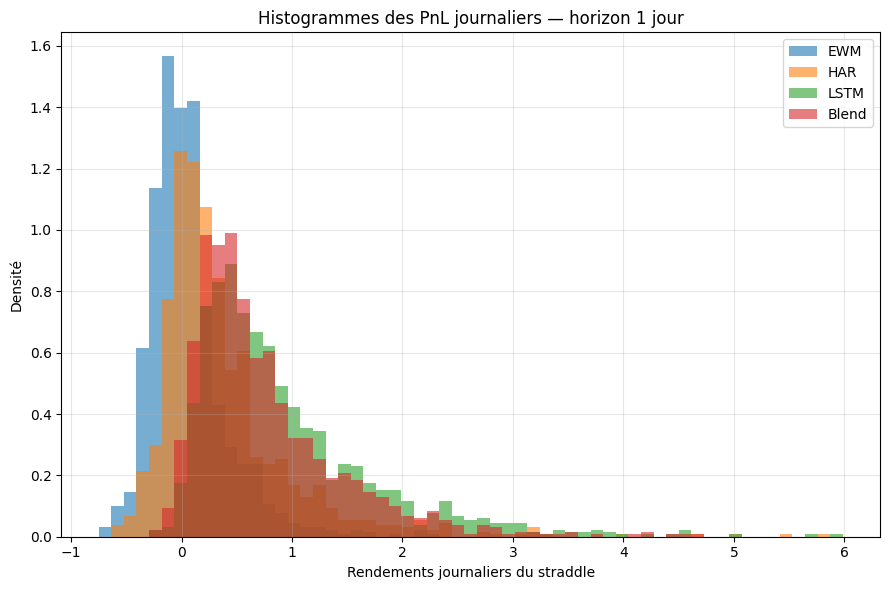

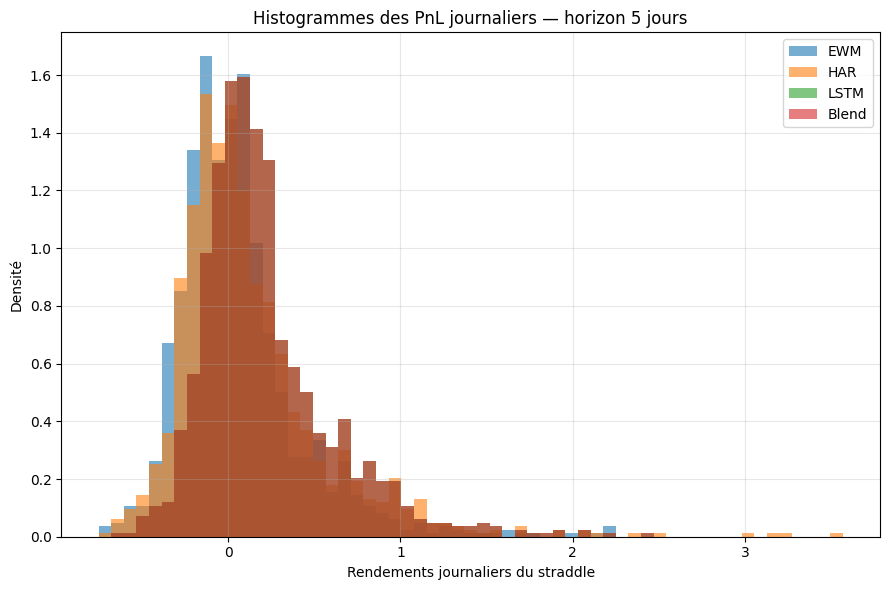

✓ Figures enregistrées : data\backtests\options\ret_hist_sigma1.png data\backtests\options\ret_hist_vol5f.png


In [10]:
# === Figure W : Histogrammes des PnL journaliers par modèle (h=1j & 5j) ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path("data/backtests/options")
FILES = {
    "sigma1": BASE / "bt_straddle_sigma1.csv",   # horizon 1 jour
    "vol5f":  BASE / "bt_straddle_vol5f.csv",    # horizon 5 jours
}
OUTS = {
    "hist_sigma1": BASE / "ret_hist_sigma1.png",
    "hist_vol5f":  BASE / "ret_hist_vol5f.png",
}

def load_bt(path):
    df = pd.read_csv(path)
    # détecter colonnes standard
    model_col = "model" if "model" in df.columns else "Modèle"
    ret_col = "ret" if "ret" in df.columns else "return"
    return df[[model_col, ret_col]].rename(columns={model_col:"model", ret_col:"ret"}).dropna()

def hist_returns(df, title, out_png):
    models = [m for m in ["EWM","HAR","LSTM","Blend"] if m in df["model"].unique()]
    if not models:
        models = sorted(df["model"].unique())

    plt.figure(figsize=(9,6))
    bins = np.linspace(df["ret"].min(), df["ret"].max(), 60)

    for m in models:
        subset = df.loc[df["model"]==m, "ret"]
        plt.hist(subset, bins=bins, alpha=0.6, density=True, label=m)

    plt.xlabel("Rendements journaliers du straddle")
    plt.ylabel("Densité")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    out_png.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png, dpi=200)
    plt.show()

# === Génération des deux histogrammes ===
df1 = load_bt(FILES["sigma1"])
hist_returns(df1, "Histogrammes des PnL journaliers — horizon 1 jour", OUTS["hist_sigma1"])

df5 = load_bt(FILES["vol5f"])
hist_returns(df5, "Histogrammes des PnL journaliers — horizon 5 jours", OUTS["hist_vol5f"])

print("✓ Figures enregistrées :", OUTS["hist_sigma1"], OUTS["hist_vol5f"])


In [11]:
# === Tableau Y : t-tests pairés (PnL des modèles vs EWM) — p-values en notation scientifique ===
import pandas as pd
from pathlib import Path

OUT = Path("data/backtests/options")

# Charger les résultats des t-tests
df1 = pd.read_csv(OUT / "bt_straddle_sigma1_ttests.csv")  # horizon 1 jour
df5 = pd.read_csv(OUT / "bt_straddle_vol5f_ttests.csv")   # horizon 5 jours

# Ajouter une colonne horizon
df1.insert(0, "Horizon", "1 jour")
df5.insert(0, "Horizon", "5 jours")

# Fusionner
tableau_Y_ttest = pd.concat([df1, df5], ignore_index=True)

# Standardiser les noms de colonnes
ren = {}
for c in tableau_Y_ttest.columns:
    lc = c.lower()
    if "pair" in lc or "compar" in lc or "model" in lc:
        ren[c] = "Comparaison"
    if "stat" in lc and "t" in lc:
        ren[c] = "t_stat"
    if "pval" in lc or "p-val" in lc or lc == "pvalue" or lc == "p_value":
        ren[c] = "p_value"
    if lc == "n" or "count" in lc:
        ren[c] = "n"
tableau_Y_ttest = tableau_Y_ttest.rename(columns=ren)

# Convertir en numérique & formater
if "t_stat" in tableau_Y_ttest.columns:
    tableau_Y_ttest["t_stat"] = pd.to_numeric(tableau_Y_ttest["t_stat"], errors="coerce").round(4)
if "p_value" in tableau_Y_ttest.columns:
    tableau_Y_ttest["p_value"] = pd.to_numeric(tableau_Y_ttest["p_value"], errors="coerce")
    # p-values en notation scientifique (3 chiffres significatifs)
    tableau_Y_ttest["p_value"] = tableau_Y_ttest["p_value"].map(lambda x: f"{x:.3e}" if pd.notnull(x) else "")

# Colonnes finales (garde "n" si utile)
cols = [c for c in ["Horizon", "Comparaison", "n", "t_stat", "p_value"] if c in tableau_Y_ttest.columns]
tableau_Y_ttest = tableau_Y_ttest[cols]

# Export CSV + Markdown
tableau_Y_ttest.to_csv(OUT / "Tableau_Y_ttests.csv", index=False)
md = tableau_Y_ttest.to_markdown(index=False)  # p_value déjà formatée en str
(Path(OUT / "Tableau_Y_ttests.md")).write_text(md, encoding="utf-8")

print("== Tableau Y : Résultats t-tests pairés (vs EWM) — p-values en notation scientifique ==\n")
print(md)


== Tableau Y : Résultats t-tests pairés (vs EWM) — p-values en notation scientifique ==

| Horizon   | Comparaison   |    n |   t_stat |    p_value |
|:----------|:--------------|-----:|---------:|-----------:|
| 1 jour    | LSTM vs EWM   | 1141 |  46.6252 | 2.023e-266 |
| 1 jour    | LSTM vs HAR   | 1141 |  33.2069 | 1.056e-169 |
| 1 jour    | Blend vs LSTM | 1141 | -36.718  | 1.933e-195 |
| 1 jour    | Blend vs EWM  | 1141 |  49.2585 | 1.322e-284 |
| 1 jour    | HAR vs EWM    | 1141 |  25.3373 | 1.036e-112 |
| 5 jours   | LSTM vs EWM   | 1141 |  24.4477 | 1.804e-106 |
| 5 jours   | LSTM vs HAR   | 1141 |  10.3903 | 3.182e-24  |
| 5 jours   | Blend vs LSTM | 1141 |   1.5522 | 0.1209     |
| 5 jours   | Blend vs EWM  | 1141 |  24.4477 | 1.804e-106 |
| 5 jours   | HAR vs EWM    | 1141 |   8.6144 | 2.309e-17  |


In [12]:
# === VOL5F_ONLY_SUMMARY_AND_TTESTS (fixed) ===
from pathlib import Path
import pandas as pd, numpy as np
from scipy import stats
from IPython.display import display

OUT = Path("data/backtests/options")
PATH = OUT / "bt_straddle_vol5f.csv"  # fichier combiné h=5 jours

# --- Lecture + normalisation unité (fraction) ---
df = pd.read_csv(PATH)
for col in ("start","end","date"):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

ret_col = next((c for c in ["ret","return","pnl","ret_pct","ret_percent"] if c in df.columns), None)
if ret_col is None:
    raise ValueError(f"{PATH.name} sans colonne 'ret' (ou équivalent). Colonnes: {df.columns.tolist()}")

x = pd.to_numeric(df[ret_col], errors="coerce").astype(np.float64)
q99 = np.nanquantile(np.abs(x), 0.99) if np.isfinite(x).any() else 0.0
if q99 > 10:  # en pourcents -> fraction
    x = x / 100.0
df["ret"] = x

# --- Extraction par modèle (format long OU wide) ---
def extract_series(df_in: pd.DataFrame, model_key: str) -> pd.DataFrame | None:
    # long ?
    for mc in ("model","strategy","name","algo","method"):
        if mc in df_in.columns:
            vals = df_in[mc].astype(str).str.lower()
            sel = vals.str.contains(model_key.lower())
            if sel.any():
                out = df_in.loc[sel, ["ret"] + [c for c in ("start","end") if c in df_in.columns]].reset_index(drop=True)
                return out
            break
    # wide
    candidates = [c for c in df_in.columns
                  if (c.lower().startswith("ret") and model_key.lower() in c.lower()) or (c.lower()==model_key.lower())]
    if not candidates:
        candidates = [c for c in df_in.columns if model_key.lower() in c.lower() and c not in ("start","end","date","ret")]
    if not candidates:
        return None
    col = candidates[0]
    out = pd.DataFrame({"ret": pd.to_numeric(df_in[col], errors="coerce").astype(np.float64)})
    for c in ("start","end"):
        if c in df_in.columns: out[c] = df_in[c]
    return out.dropna(subset=["ret"])

wanted = ["ewm","har","lstm"]  # ajoute "blend","egarch","gjr" si dispo dans ton CSV
series = {k: extract_series(df, k) for k in wanted}
series = {k:v for k,v in series.items() if v is not None and len(v)}
print("Modèles détectés (vol5f):", list(series.keys()))

# --- Résumés + sauvegarde _fixed ---
def summarize(sdf: pd.DataFrame) -> pd.Series:
    r = sdf["ret"].to_numpy(np.float64)
    return pd.Series({"n": r.size, "mean": np.nanmean(r), "std": np.nanstd(r, ddof=1),
                      "median": np.nanmedian(r), "p_win": float(np.nanmean(r>0))})

sum_df = pd.DataFrame({k.upper(): summarize(v) for k,v in series.items()}).T
sum_df_round = sum_df.copy()
sum_df_round[["mean","std","median"]] = sum_df_round[["mean","std","median"]].round(6)

out_sum = OUT / "bt_straddle_vol5f_summary_fixed.csv"
sum_df_round.to_csv(out_sum)
display(sum_df_round)
print("✓ Sauvé :", out_sum)

# --- t-tests appariés (si start/end présents sinon alignement par index) ---
def align(a: pd.DataFrame, b: pd.DataFrame):
    if all(c in a.columns for c in ("start","end")) and all(c in b.columns for c in ("start","end")):
        m = a.merge(b, on=["start","end"], suffixes=("_a","_b"))
        return m["ret_a"].to_numpy(), m["ret_b"].to_numpy(), len(m)
    n = min(len(a), len(b))
    return a["ret"].values[:n], b["ret"].values[:n], n

def paired_t(A: pd.DataFrame, B: pd.DataFrame):
    xa, xb, n = align(A,B)
    t, p = stats.ttest_rel(xa, xb, nan_policy="omit")
    return float(t), float(p), int(n)

pairs = []
if all(k in series for k in ("har","ewm")):   pairs.append(("HAR vs EWM",  series["har"],  series["ewm"]))
if all(k in series for k in ("lstm","ewm")):  pairs.append(("LSTM vs EWM", series["lstm"], series["ewm"]))
if all(k in series for k in ("lstm","har")):  pairs.append(("LSTM vs HAR", series["lstm"], series["har"]))

if pairs:
    tt = pd.DataFrame([{"pair": name, **dict(zip(["t","p","n"], paired_t(A,B)))} for name,A,B in pairs])
    out_tt = OUT / "bt_straddle_vol5f_ttests_fixed.csv"
    tt.to_csv(out_tt, index=False)
    display(tt)
    print("✓ Sauvé :", out_tt)

# --- Petit tableau prêt à coller dans le rapport (h=5) ---
tab = sum_df_round.assign(Sharpe=(sum_df["mean"]/sum_df["std"])).rename(
    columns={"mean":"Ret moyen","std":"Ret écart-type"})
tab = tab[["Ret moyen","Ret écart-type"]].assign(**{"Sharpe (mean/std, par trade)": (sum_df["mean"]/sum_df["std"]).round(3)})
print("\nTableau 3 (H = 5 jours) — prêt à coller :\n")
print(tab.to_markdown())


Modèles détectés (vol5f): ['ewm', 'har', 'lstm']


,n,mean,std,median,p_win
EWM,1141.0,0.058709,0.362495,0.000648,0.503067
HAR,1141.0,0.127632,0.448827,0.017874,0.533742
LSTM,1141.0,0.218025,0.384721,0.135961,0.715162


✓ Sauvé : data\backtests\options\bt_straddle_vol5f_summary_fixed.csv


,pair,t,p,n
0,HAR vs EWM,8.614408,2.308637e-17,1141
1,LSTM vs EWM,24.447677,1.803543e-106,1141
2,LSTM vs HAR,10.390286,3.182079e-24,1141


✓ Sauvé : data\backtests\options\bt_straddle_vol5f_ttests_fixed.csv

Tableau 3 (H = 5 jours) — prêt à coller :

|      |   Ret moyen |   Ret écart-type |   Sharpe (mean/std, par trade) |
|:-----|------------:|-----------------:|-------------------------------:|
| EWM  |    0.058709 |         0.362495 |                          0.162 |
| HAR  |    0.127632 |         0.448827 |                          0.284 |
| LSTM |    0.218025 |         0.384721 |                          0.567 |
